In [1]:
import math
import scipy
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy import optimize
from tqdm import trange, tqdm
from matplotlib import animation

from IPython.display import clear_output

In [2]:
tree_filename = "tree.jpg"
tree1_filename = "tree1.jpg"
tree2_filename = "tree2.jpg"
tree3_filename = "tree3.jpg"
tree_img = Image.open("../inputs/" + tree_filename)
tree1_img = Image.open("../inputs/" + tree1_filename)
tree2_img = Image.open("../inputs/" + tree2_filename)
tree3_img = Image.open("../inputs/" + tree3_filename)
tree1_img = tree1_img.resize(tree_img.size)

In [3]:
tree_arr = np.array(tree_img)
tree1_arr = np.array(tree1_img)
tree2_arr = np.array(tree2_img)
tree3_arr = np.array(tree3_img)[:360]

print(tree_arr.shape)
print(tree1_arr.shape)
print(tree2_arr.shape)
print(tree3_arr.shape)

(360, 600, 3)
(360, 600, 3)
(360, 600, 3)
(360, 600, 3)


In [4]:
def show_images(arr0, arr1, arr2, arr3):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 4, 1)
    plt.imshow(arr0)
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(arr1)
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(arr2)
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(arr3)
    plt.axis("off")

    plt.show()

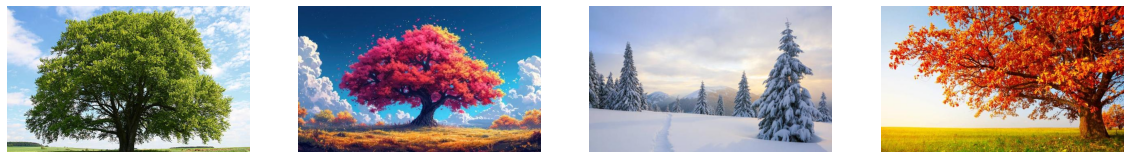

In [5]:
show_images(tree_arr, tree1_arr, tree2_arr, tree3_arr)

In [6]:
def transfer_pixel(imgSrc, imgTar, B=25):
    if len(imgTar.shape) == 2:
        rows, cols = imgTar.shape
        ch = 1
        final_arr = np.full((rows, cols), 255, dtype=imgSrc.dtype)
    else:
        rows, cols, ch = imgTar.shape
        final_arr = np.full((rows, cols, ch), 255, dtype=imgSrc.dtype)
    
    r = rows // B
    c = cols // B
            
    cost_matrix = np.empty((r,c,r,c,ch))

    srcAvg = np.empty((r,c,ch))
    tarAvg = np.empty((r,c,ch))

    for i in range(r):
        for j in range(c):
            srcAvg[i,j] = np.average(imgSrc[i*B:i*B+B, j*B:j*B+B], axis=(0,1))
            tarAvg[i,j] = np.average(imgTar[i*B:i*B+B, j*B:j*B+B], axis=(0,1))

    for i in range(r):
            for j in range(c):
                cost_matrix[i,j] = tarAvg[i,j] -  srcAvg

    cost_matrix = np.linalg.norm(cost_matrix, axis=-1)


    temp = cost_matrix.reshape(r, c, r*c).transpose(2,0,1).reshape(r*c, r*c).transpose(1,0)
    _, col_ind = optimize.linear_sum_assignment(temp)

    coords = col_ind.reshape(r,c)

    for i in range(r):
        for j in range(c):
            temp = coords[i,j]
            i2 = temp // c
            j2 = temp % c
            
            final_arr[i*B:i*B+B, j*B:j*B+B] = imgSrc[i2*B:i2*B+B, j2*B:j2*B+B].copy()
    
    return coords, final_arr

In [7]:
def transfer_pixel_improved(source_arr, target_arr, block_size=30, stride=None):
    if not stride:
        stride = block_size

    final_arr = np.array(source_arr, dtype=np.float64)
    target_arr = np.array(target_arr, dtype=np.float64)

    for i in range(0, target_arr.shape[0] - block_size + 1, stride):
        for j in trange(0, target_arr.shape[1] - block_size + 1, stride):
            srcBlock = final_arr [i:i+block_size, j:j+block_size, :]
            trgBlock = target_arr[i:i+block_size, j:j+block_size, :]

            ms = srcBlock.mean(axis=(0, 1))
            srcBlock = srcBlock - ms

            mt = trgBlock.mean(axis=(0, 1))
            trgBlock = trgBlock - mt

            _coords, block = transfer_pixel(srcBlock, trgBlock, B=1)
            final_arr[i:i+block_size, j:j+block_size, :] = block + ms

        clear_output()
        plt.figure(figsize=(10, 10))
        plt.imshow(final_arr / 255)
        plt.show()
    
    return final_arr

In [8]:
_, final_block1_arr = transfer_pixel(tree1_arr, tree_arr, B=10)
_, final_block2_arr = transfer_pixel(tree2_arr, tree_arr, B=10)
_, final_block3_arr = transfer_pixel(tree3_arr, tree_arr, B=10)
plt.imsave("../outputs/4/before_improved_1_block10.png", np.array(final_block1_arr, dtype=np.uint8))
plt.imsave("../outputs/4/before_improved_2_block10.png", np.array(final_block2_arr, dtype=np.uint8))
plt.imsave("../outputs/4/before_improved_3_block10.png", np.array(final_block3_arr, dtype=np.uint8))

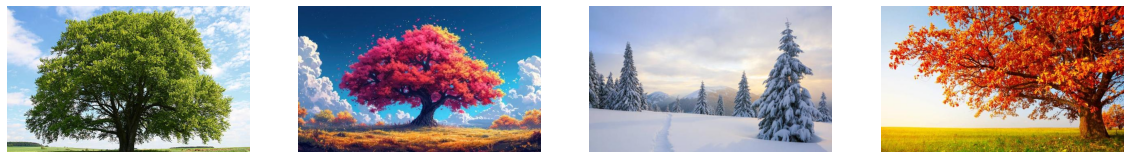

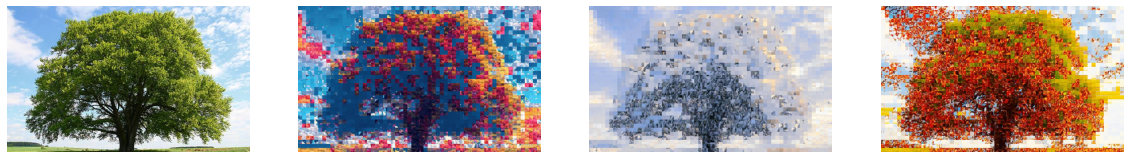

In [9]:
show_images(tree_arr, tree1_arr, tree2_arr, tree3_arr)
show_images(tree_arr, final_block1_arr, final_block2_arr, final_block3_arr)

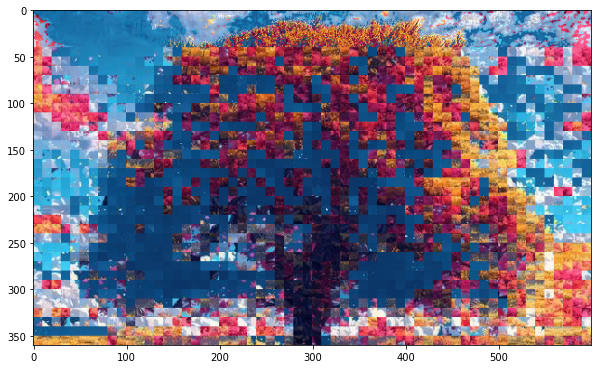

 92%|█████████▏| 106/115 [00:20<00:02,  4.16it/s]

In [10]:
improved1_30X30_5X5 = transfer_pixel_improved(final_block1_arr, tree_arr, block_size=30, stride=5)
plt.imsave("../outputs/4/improved_domain_shift1_block30_stride5.png", np.array(improved1_30X30_5X5, dtype=np.uint8))

In [ ]:
improved2_30X30_5X5 = transfer_pixel_improved(final_block2_arr, tree_arr, block_size=30, stride=5)
plt.imsave("../outputs/4/improved_domain_shift2_block30_stride5.png", np.array(improved2_30X30_5X5, dtype=np.uint8))

In [ ]:
improved3_30X30_5X5 = transfer_pixel_improved(final_block3_arr, tree_arr, block_size=30, stride=5)
plt.imsave("../outputs/4/improved_domain_shift3_block30_stride5.png", np.array(improved3_30X30_5X5, dtype=np.uint8))

# from grayscale image

In [ ]:
tree_gray_arr = 0.299 * tree_arr[:,:, 0] + 0.587 * tree_arr[:,:, 1] + 0.114 * tree_arr[:,:, 2]

In [ ]:
tree_gray_arr = np.stack([
    tree_gray_arr,
    tree_gray_arr,
    tree_gray_arr, ]
    , axis=-1)

In [ ]:
_, final_gray_block1_arr = transfer_pixel(tree1_arr, tree_arr, B=10)
_, final_gray_block2_arr = transfer_pixel(tree2_arr, tree_arr, B=10)
_, final_gray_block3_arr = transfer_pixel(tree3_arr, tree_arr, B=10)
plt.imsave("../outputs/4/before_improved_gray_1_block10.png", np.array(final_gray_block1_arr, dtype=np.uint8))
plt.imsave("../outputs/4/before_improved_gray_2_block10.png", np.array(final_gray_block2_arr, dtype=np.uint8))
plt.imsave("../outputs/4/before_improved_gray_3_block10.png", np.array(final_gray_block3_arr, dtype=np.uint8))

In [ ]:
print("orginal")
show_images(tree_arr, tree1_arr, tree2_arr, tree3_arr)

print("rgb source:")
show_images(tree_arr, final_block1_arr, final_block2_arr, final_block3_arr)

print("gray source:")
show_images(tree_arr, final_gray_block1_arr, final_gray_block2_arr, final_gray_block3_arr)

In [ ]:
improved1_gray_30X30_5X5 = transfer_pixel_improved(final_gray_block1_arr, tree_gray_arr, block_size=30, stride=5)
plt.imsave("../outputs/4/improved_colorize1_block30_stride5.png", np.array(improved1_gray_30X30_5X5, dtype=np.uint8))

In [ ]:
improved2_gray_30X30_5X5 = transfer_pixel_improved(final_gray_block2_arr, tree_gray_arr, block_size=30, stride=5)
plt.imsave("../outputs/4/improved_colorize2_block30_stride5.png", np.array(improved2_gray_30X30_5X5, dtype=np.uint8))

In [ ]:
improved3_gray_30X30_5X5 = transfer_pixel_improved(final_gray_block3_arr, tree_gray_arr, block_size=30, stride=5)
plt.imsave("../outputs/4/improved_colorize3_block30_stride5.png", np.array(improved3_gray_30X30_5X5, dtype=np.uint8))